# Model Training 
# Only Graph-based Features

In [25]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import shap
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from joblib import dump, load


In [2]:
data = pd.read_csv('/kaggle/input/process-dataset/chess_features.csv')
data.head()

,min_degree,max_degree,avg_degree,deg_dist_1,deg_dist_2,deg_dist_3,deg_dist_4,deg_dist_5,density,node_count,...,nodes_3_core,nodes_2_core,rich_club_coeff,ratio_friendly_to_opposing,ratio_opposing_to_friendly,avg_friendly_to_opposing,avg_opposing_to_friendly,pct_friendly_to_opposing,pct_opposing_in_degree_gt0,y_label
0,1,5,2.375,0.00,37.50,25.0,12.50,25.00,0.158333,16,...,0,6,0,0.000000,0.0,0.0000,0.0,0.00,0.0,neutral
1,1,5,2.000,0.00,50.00,25.0,6.25,18.75,0.133333,16,...,0,4,0,0.000000,0.0,0.0000,0.0,0.00,0.0,weak
2,1,5,2.000,0.00,50.00,25.0,6.25,18.75,0.133333,16,...,0,4,0,0.058824,0.0,0.0625,0.0,6.25,0.0,weak
3,1,4,1.875,6.25,43.75,25.0,6.25,18.75,0.125000,16,...,0,4,0,0.062500,0.0,0.0625,0.0,6.25,0.0,weak
4,1,5,2.500,0.00,31.25,37.5,0.00,31.25,0.166667,16,...,0,9,0,0.047619,0.0,0.0625,0.0,6.25,0.0,neutral


In [3]:
    feature_names = [
        'min_degree', 'max_degree', 'avg_degree',
        'deg_dist_1', 'deg_dist_2', 'deg_dist_3', 'deg_dist_4', 'deg_dist_5',
        'density', 'node_count', 'edge_count', 'num_wcc_large', 'num_scc_large',
        'num_trees', 'pct_nodes_wcc_large', 'pct_nodes_scc_large', 'pct_nodes_trees',
        'pct_nodes_wcc_size1', 'pct_smallest_wcc', 'pct_largest_wcc', 'avg_pct_wcc_large',
        'wcc_size_dist_1', 'wcc_size_dist_2', 'wcc_size_dist_3',
        'min_wcc_diameter', 'max_wcc_diameter', 'avg_wcc_diameter',
        'wcc_diam_dist_1', 'wcc_diam_dist_2', 'wcc_diam_dist_3',
        'pct_smallest_scc', 'pct_largest_scc', 'avg_pct_scc_large',
        'scc_size_dist_1', 'scc_size_dist_2', 'scc_size_dist_3',
        'min_scc_diameter', 'max_scc_diameter', 'avg_scc_diameter',
        'scc_diam_dist_1', 'scc_diam_dist_2', 'scc_diam_dist_3',
        'pct_trees_size1', 'pct_smallest_tree', 'pct_largest_tree', 'avg_pct_trees_large',
        'tree_size_dist_1', 'tree_size_dist_2', 'tree_size_dist_3',
        'min_tree_depth', 'max_tree_depth', 'avg_tree_depth',
        'tree_diam_dist_1', 'tree_diam_dist_2', 'tree_diam_dist_3',
        'clustering_coeff', 'largest_clique', 'min_edge_dominating_set',
        'max_independent_set', 'smallest_maximal_matching', 'degree_assortativity',
        'transitivity', 'num_attracting_components', 'nodes_3_core', 'nodes_2_core',
        'rich_club_coeff', 'ratio_friendly_to_opposing', 'ratio_opposing_to_friendly',
        'avg_friendly_to_opposing', 'avg_opposing_to_friendly',
        'pct_friendly_to_opposing', 'pct_opposing_in_degree_gt0'
    ]

# Feature Exploration
## NULL Values

In [4]:
df = data 
columns_with_nulls = df.columns[df.isnull().any()].tolist()

print("Columns with null values:", columns_with_nulls)

Columns with null values: ['degree_assortativity']


In [5]:
fill_value = data["degree_assortativity"].mean()
data["degree_assortativity"] = data["degree_assortativity"].fillna(fill_value)


# Feature Analysis

In [6]:
summary_stats = df.iloc[:, :-1].agg(['min', 'max', 'mean', 'std', 'median']).T
summary_stats = summary_stats.rename(columns={'mean': 'avg'})
summary_stats = summary_stats.round(2)

top_var_features = summary_stats.sort_values(by='std', ascending=False).head(10)
print("🔍 Top 10 Most Variable Features:")
print(top_var_features[['avg', 'std']])


🔍 Top 10 Most Variable Features:
                       avg    std
pct_nodes_trees      26.73  35.74
pct_smallest_wcc     66.64  34.50
tree_size_dist_1     22.00  29.71
pct_largest_tree     22.00  29.71
avg_pct_wcc_large    72.20  28.20
avg_pct_trees_large  20.50  28.17
pct_smallest_tree    19.10  27.46
wcc_size_dist_1      78.01  24.45
pct_nodes_wcc_size1  13.00  21.29
pct_nodes_wcc_large  87.00  21.29


- Note: Random Forest does **not require normalization** since it is scale-invariant and uses threshold-based splits.
  


# Class Distribution

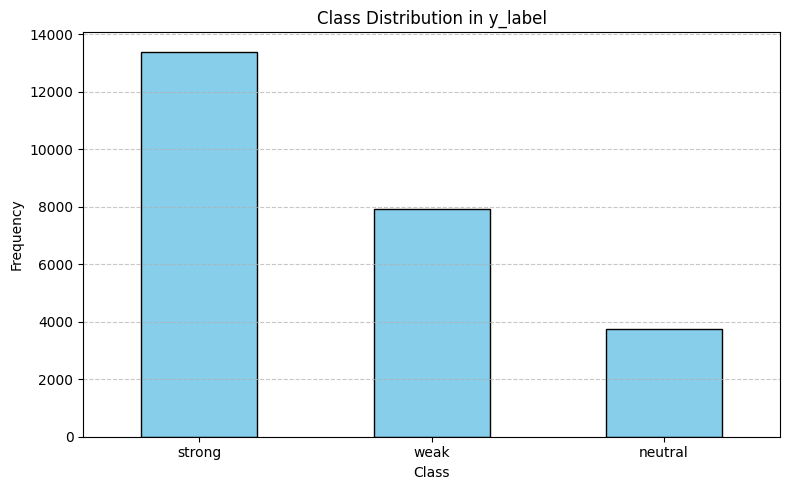

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = data  # Replace with your actual file path

# Get class distribution
class_distribution = df['y_label'].value_counts()

# Plot histogram
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution in y_label')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [35]:
df['y_label'].value_counts()

y_label
strong     13389
weak        7912
neutral     3732
Name: count, dtype: int64

In [7]:
import pandas as pd

# Check the class distribution
class_counts = data['y_label'].value_counts()
print("Class distribution before sampling:")
print(class_counts)


target_size = min(class_counts.min(), 3500)  # Use 3,500 or the smallest class size, whichever is smaller
print(f"Target sample size per class: {target_size}")

strong_df = data[data['y_label'] == 'strong'].sample(n=3500, random_state=42)
weak_df = data[data['y_label'] == 'weak'].sample(n=3500, random_state=42)
neutral_df = data[data['y_label'] == 'neutral'].sample(n=3500, random_state=42)


data_balanced = pd.concat([strong_df, weak_df, neutral_df], ignore_index=True)


print("\nClass distribution after sampling:")
print(data_balanced['y_label'].value_counts())

Class distribution before sampling:
y_label
strong     13389
weak        7912
neutral     3732
Name: count, dtype: int64
Target sample size per class: 3500

Class distribution after sampling:
y_label
strong     3500
weak       3500
neutral    3500
Name: count, dtype: int64


In [8]:
data = data_balanced

In [9]:

from sklearn.model_selection import train_test_split

# Split features (X) and labels (y)
X = data.drop('y_label', axis=1)
y = data['y_label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())




Train class distribution:
 y_label
weak       3150
neutral    3150
strong     3150
Name: count, dtype: int64
Test class distribution:
 y_label
strong     350
neutral    350
weak       350
Name: count, dtype: int64


# Train the Model from scratch

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from joblib import dump, load
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")



# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}


grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Display best results
print(" Best Parameters from GridSearch:")
print(grid_search.best_params_)
print("Test Set Accuracy with Best Model:", test_accuracy)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best Parameters from GridSearch:
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Test Set Accuracy with Best Model: 0.5066666666666667


# Save Model 

In [14]:
dump(best_model, 'rf_model_for_only_graph_features.joblib')


['rf_model_for_only_graph_features.joblib']

# Load Model 

In [15]:
model_path = "rf_model_for_only_graph_features.joblib"

In [16]:
best_model = load(model_path)

# 

In [17]:
print(classification_report(y_test, y_pred))
print("Test Set Accuracy:", test_accuracy)

              precision    recall  f1-score   support

     neutral       0.49      0.41      0.45       350
      strong       0.55      0.71      0.62       350
        weak       0.45      0.40      0.42       350

    accuracy                           0.51      1050
   macro avg       0.50      0.51      0.50      1050
weighted avg       0.50      0.51      0.50      1050

Test Set Accuracy: 0.5066666666666667


# Relative Importance

In [51]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import shap

sample_size = 0.1
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)

for sample_idx, _ in sss.split(X_test, y_test):
    X_test_sample = X_test.iloc[sample_idx]
    y_test_sample = y_test.iloc[sample_idx]

explainer = shap.TreeExplainer(best_model)
shap_values_sample = explainer.shap_values(X_test_sample)

n_classes = len(shap_values_sample)
shap_values_all_sample = np.zeros((n_classes * X_test_sample.shape[0], X_test_sample.shape[1]))

for c in range(n_classes):
    shap_values_all_sample[c * X_test_sample.shape[0]:(c + 1) * X_test_sample.shape[0], :] = shap_values_sample[c]


feature_importance_sample = np.abs(shap_values_all_sample).mean(axis=0)

In [52]:
importance_df_sample = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': feature_importance_sample
}).sort_values(by='shap_importance', ascending=False)
print("Random Forest SHAP Feature Importances (sampled):")
print(importance_df_sample)


Random Forest SHAP Feature Importances (sampled):
                       feature  shap_importance
9                   node_count         0.029443
10                  edge_count         0.021021
57     min_edge_dominating_set         0.012989
68    avg_friendly_to_opposing         0.010343
59   smallest_maximal_matching         0.010327
..                         ...              ...
41             scc_diam_dist_3         0.000126
65             rich_club_coeff         0.000000
67  ratio_opposing_to_friendly         0.000000
69    avg_opposing_to_friendly         0.000000
71  pct_opposing_in_degree_gt0         0.000000

[72 rows x 2 columns]


- Since the **accuracy is low**, the relative importance of the features would not be significant importance.

#  Model Training & Testing 
## Graph-based + domain-specific features


In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import shap
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score


In [26]:
data = pd.read_csv('/kaggle/input/chess-v2-changed-feature/chess_features.csv')
data.head()

,white_pawns,white_knights,white_bishops,white_rooks,white_queens,white_kings,black_pawns,black_knights,black_bishops,black_rooks,...,support_clustering,support_nodes,support_edges,support_centrality,mobility_avg_degree,mobility_clustering,mobility_nodes,mobility_edges,mobility_centrality,y_label
0,8,2,2,2,1,1,8,2,2,2,...,0.094792,32,37,0.070565,0.62500,0.0,64,20,0.009921,neutral
1,8,2,2,2,1,1,8,2,2,2,...,0.068750,32,34,0.064516,0.84375,0.0,64,27,0.013393,neutral
2,8,2,2,2,1,1,8,2,2,2,...,0.070833,32,33,0.062500,0.87500,0.0,64,28,0.013889,weak
3,8,2,2,2,1,1,8,2,2,2,...,0.072917,32,37,0.070565,0.93750,0.0,64,30,0.014881,weak
4,8,2,2,2,1,1,8,2,2,2,...,0.036458,32,37,0.070565,0.93750,0.0,64,30,0.014881,neutral


# Dataset Distribution 

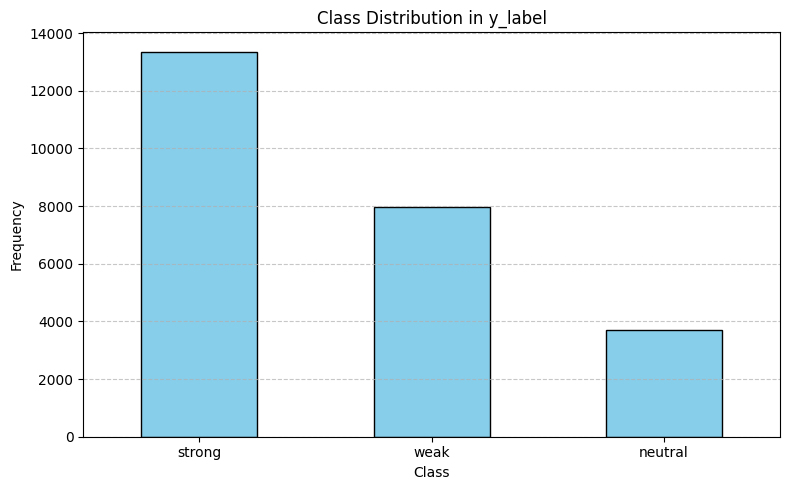

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


df = data  
class_distribution = df['y_label'].value_counts()
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution in y_label')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Feature Exploration
## Null Values 

In [4]:
columns_with_nulls = df.columns[df.isnull().any()].tolist()

print("Columns with null values:", columns_with_nulls)

Columns with null values: []


#  Feature Analysis

In [5]:
summary_stats = df.iloc[:, :-1].agg(['min', 'max', 'mean', 'std', 'median']).T
summary_stats = summary_stats.rename(columns={'mean': 'avg'})
summary_stats = summary_stats.round(2)

top_var_features = summary_stats.sort_values(by='std', ascending=False).head(10)
print("🔍 Top 10 Most Variable Features:")
print(top_var_features[['avg', 'std']])


🔍 Top 10 Most Variable Features:
                     avg     std
black_pawn_pst    188.98  107.28
white_pawn_pst    191.61  104.56
black_knight_pst   -8.73   27.66
white_knight_pst   -7.59   26.25
support_edges      24.87   14.33
mobility_edges     28.37   12.18
white_king_pst    -41.31    8.97
black_bishop_pst   -2.96    8.87
white_bishop_pst   -2.14    8.87
black_king_pst    -41.65    8.27


- Note: Random Forest does **not require normalization** since it is scale-invariant and uses threshold-based splits.
  


# Balancing Dataset 

In [27]:
import pandas as pd

# Check the class distribution
class_counts = data['y_label'].value_counts()
print("Class distribution before sampling:")
print(class_counts)


target_size = min(class_counts.min(), 3500)  # Use 3,500 or the smallest class size, whichever is smaller
print(f"Target sample size per class: {target_size}")

strong_df = data[data['y_label'] == 'strong'].sample(n=3500, random_state=42)
weak_df = data[data['y_label'] == 'weak'].sample(n=3500, random_state=42)
neutral_df = data[data['y_label'] == 'neutral'].sample(n=3500, random_state=42)


data_balanced = pd.concat([strong_df, weak_df, neutral_df], ignore_index=True)


print("\nClass distribution after sampling:")
print(data_balanced['y_label'].value_counts())

Class distribution before sampling:
y_label
strong     13359
weak        7963
neutral     3711
Name: count, dtype: int64
Target sample size per class: 3500

Class distribution after sampling:
y_label
strong     3500
weak       3500
neutral    3500
Name: count, dtype: int64


# Feature-Set

In [28]:
  feature_names = [
        # Material features (12): 6 for player, 6 for opponent
        'player_pawns', 'player_knights', 'player_bishops', 'player_rooks', 'player_queens', 'player_kings',
        'opponent_pawns', 'opponent_knights', 'opponent_bishops', 'opponent_rooks', 'opponent_queens', 'opponent_kings',
        # Piece-square features (12): 6 for player, 6 for opponent
        'player_pawn_pst', 'player_knight_pst', 'player_bishop_pst', 'player_rook_pst', 'player_queen_pst', 'player_king_pst',
        'opponent_pawn_pst', 'opponent_knight_pst', 'opponent_bishop_pst', 'opponent_rook_pst', 'opponent_queen_pst', 'opponent_king_pst',
        # Mobility features (10): 5 for player, 5 for opponent
        'player_knight_mobility', 'player_bishop_mobility', 'player_rook_mobility', 'player_queen_mobility', 'player_king_mobility',
        'opponent_knight_mobility', 'opponent_bishop_mobility', 'opponent_rook_mobility', 'opponent_queen_mobility', 'opponent_king_mobility',
        # King safety features (4): 2 for player, 2 for opponent
        'player_king_center_dist', 'player_king_pawn_shield', 'opponent_king_center_dist', 'opponent_king_pawn_shield',
        # Pawn structure features (8): 4 for player, 4 for opponent
        'player_doubled_pawns', 'player_isolated_pawns', 'player_passed_pawns', 'player_pawn_chains',
        'opponent_doubled_pawns', 'opponent_isolated_pawns', 'opponent_passed_pawns', 'opponent_pawn_chains',
        # Network-based features (10): Shared for the board
        'support_avg_degree', 'support_clustering', 'support_nodes', 'support_edges', 'support_centrality',
        'mobility_avg_degree', 'mobility_clustering', 'mobility_nodes', 'mobility_edges', 'mobility_centrality'
    ]

In [29]:
data = data_balanced

#  Train-Test Split

In [30]:

from sklearn.model_selection import train_test_split

# Split features (X) and labels (y)
X = data.drop('y_label', axis=1)
y = data['y_label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
print("Train class distribution:\n", y_train.value_counts())
print("Test class distribution:\n", y_test.value_counts())




Train class distribution:
 y_label
weak       3150
neutral    3150
strong     3150
Name: count, dtype: int64
Test class distribution:
 y_label
strong     350
neutral    350
weak       350
Name: count, dtype: int64


# Model Training and Testing

# Train the model from Scratch

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")



# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}


grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

# Display best results
print(" Best Parameters from GridSearch:")
print(grid_search.best_params_)
print("Test Set Accuracy with Best Model:", test_accuracy)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best Parameters from GridSearch:
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Test Set Accuracy with Best Model: 0.7447619047619047


# Save the model

In [31]:
dump(best_model, 'rf_model_for_mix_features.joblib')

['rf_model_for_mix_features.joblib']

# Load the model 

In [32]:
model_path = "rf_model_for_mix_features.joblib"

In [33]:
best_model = load(model_path)

In [34]:
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

     neutral       0.76      0.70      0.73       350
      strong       0.81      0.85      0.83       350
        weak       0.67      0.68      0.68       350

    accuracy                           0.74      1050
   macro avg       0.74      0.74      0.74      1050
weighted avg       0.74      0.74      0.74      1050

Random Forest Accuracy: 0.7447619047619047


# SHAP

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import shap



n_runs = 5
sample_size = 0.1
all_importances = []

explainer = shap.TreeExplainer(best_model)

for _ in range(n_runs):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=np.random.randint(10000))
    for sample_idx, _ in sss.split(X_test, y_test):
        X_sample = X_test.iloc[sample_idx]
        y_sample = y_test.iloc[sample_idx]

    shap_values = explainer.shap_values(X_sample)
    n_classes = len(shap_values)
    shap_all = np.zeros((n_classes * X_sample.shape[0], X_sample.shape[1]))

    for c in range(n_classes):
        shap_all[c * X_sample.shape[0]:(c + 1) * X_sample.shape[0], :] = shap_values[c]

    feature_importance = np.abs(shap_all).mean(axis=0)
    all_importances.append(feature_importance)

# Average importance over all runs
mean_importance = np.mean(all_importances, axis=0)


In [27]:
importance_df_sample = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': mean_importance
}).sort_values(by='shap_importance', ascending=False)
print("Random Forest SHAP Feature Importances (sampled):")
print(importance_df_sample)


Random Forest SHAP Feature Importances (sampled):
                      feature  shap_importance
12            player_pawn_pst         0.025716
48              support_nodes         0.024785
18          opponent_pawn_pst         0.019950
49              support_edges         0.019449
0                player_pawns         0.015942
6              opponent_pawns         0.012155
32    opponent_queen_mobility         0.011313
1              player_knights         0.009610
8            opponent_bishops         0.009450
10            opponent_queens         0.009273
31     opponent_rook_mobility         0.009149
26       player_rook_mobility         0.008225
46         support_avg_degree         0.007498
7            opponent_knights         0.007352
27      player_queen_mobility         0.007211
29   opponent_knight_mobility         0.007130
9              opponent_rooks         0.006701
2              player_bishops         0.006562
22         opponent_queen_pst         0.006463
50        